# Linear Methods for Regression

## 0.背景知识

##### 线性模型
使用输入变量$\mathbf{X}^T = (X_1,X_2,...X_p)$来预测输出变量$Y$
$$
f(\mathbf{X})=\beta_0+\sum^p_{j=1}\mathbf{X}_j\beta_j
$$

传统我们通常使用最小二乘（least squares）的方式计算系数$\beta$：

$$
RSS(\beta) =\sum^N_{i=1}(y_i-f(x_i))^2=(\mathbf{y}-\mathbf{X}\beta)^T(\mathbf{y}-\mathbf{X}\beta)
$$

很明显$RSS(\beta)$是关于$\beta$的开口向上的一元二次函数,故而对右边$\beta$求导即可获得使min$(RSS(\beta))$的$\beta$值：
$$
-2\mathbf{X}^T(\mathbf{y}-\mathbf{X}\beta)=0,\quad \hat{\beta} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}
$$

##### MSE可以分解为3个部分

$\textbf{Bias}$:估计量是否有系统误差，比如系统的高估或者低估。它度量的事在大量重复抽样过程中，估计值$\hat{f}(x)$对于真实值$f(x)$的平均偏离程度

$\textbf{Var}$:预测模型本身的稳定性。它衡量的是在大量重复抽样过程中，估计值$\hat{f}(x)$围绕其期望值$E\hat{f}(x)$的波动幅度


$\textbf{$\epsilon$}$：噪音，刻画了当前任何算法所能够达到的期望泛化误差的下界，即刻画了问题本身的难度



$\textbf{Bias}$和$\textbf{Var}$这两者共同决定了模型的预测性能，并且存在权衡的关系。通常模型的复杂度越高，偏差就会越小，但是会造成高方差

\begin{aligned}
MSE(\hat{f}(x)) &= E[y-\hat{f}(x)]^2 \\
                 &= E[f(x)+\epsilon-\hat{f}(x)]^2 \\
                 &= E[f(x)-E\hat{f}(x)+E\hat{f}(x)-\hat{f}(x)+\epsilon]^2 \\
                 &= E[E\hat{f}(x)-f(x)]^2 + E[\hat{f}(x)-E\hat{f}(x)]^2 + E[\epsilon]^2 \\
                 & = Bias^2 + Var +\sigma^2
\end{aligned}

##### 机器学习的重要任务是预测，最小二乘估计量在这一任务上存在缺陷
1.第一，预测精度问题：最小二乘估计通常具有较低的偏差（bias），但方差（variance）较大（过拟合）。我们有时可以通过缩小或将某些系数设为零来提高预测精度。这样做虽然会引入一些偏差，但可以减少预测值的方差，从而可能提升整体的预测准确性。

2.结果的可解释性：当预测变量较多时，我们通常希望找出影响最显著的一个较小子集。为了掌握“整体趋势”，我们愿意牺牲一些细节信息

3.共线性问题,变量间存在较强相关性时可能表现不佳

##### 这里我们介绍三种方式在最小二乘的基础上改进线性回归

1. 变量子集选择（variable subset selection）

2. 收缩估计（shrinkage），岭回归和Lasso

3. 其他降维策略（dimension-reduction strategies）

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS

## Scikit-learn 的 model_selection：包含交叉验证（cross-validation）、数据拆分（train-test split）等功能
import sklearn.model_selection as skm
## Scikit-learn 的 linear_model：用于线性回归、岭回归、Lasso 回归等
import sklearn.linear_model as skl
## StandardScaler：用于标准化数据（均值0，方差1）
from sklearn.preprocessing import StandardScaler
## 于构建机器学习流水线（例如先标准化数据，再降维，再训练模型）
from sklearn.pipeline import Pipeline
## PCA（主成分分析）：用于降维，减少特征数量，同时保留尽可能多的信息
from sklearn.decomposition import PCA
## PLS 回归（偏最小二乘回归）：一种适用于高维、多共线数据的回归方法
from sklearn.cross_decomposition import PLSRegression

## Stepwise：逐步回归，用于变量筛选（类似 stepwise 方法）。
## sklearn_selected：基于 sklearn 选择特征的方法。
## sklearn_selection_path：记录模型在不同正则化参数下的特征选择路径。
from ISLP.models import \
    (Stepwise ,
     sklearn_selected ,
     sklearn_selection_path)
## l0bnb（L0 规范优化）：用于稀疏建模（L0 正则化），比 Lasso（L1 正则化）更接近真正的变量筛选
from l0bnb import fit_path


from ISLP import load_data
from ISLP.models import ModelSpec as MS  ## 用于构建和管理统计学习模型的公式
from functools import partial  ##  接受一个函数作为参数，并从左侧开始冻结该函数的一些参数


In [2]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)

## 1.Subset Selection Methods

仅保留一部分变量，并将其余变量从模型中去除。对于所保留的变量，仍然使用最小二乘回归来估计系数。选择变量子集的方法有多种不同的策略。
1.  Best Subset Selection
2. Forward Stepwise Selection

In [3]:
## 导入数据
## 回归任务目标是基于球员在前一年中的各种表现统计数据来预测其工资（Salary）
Hitters = load_data('Hitters')
Hitters.shape

(322, 20)

In [4]:
## 薪水值缺失的数量
np.isnan(Hitters['Salary']).sum()

59

In [5]:
Hitters = Hitters.dropna().reset_index(drop=True)
Hitters.shape
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
3,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


### 1.1 Best Subset Selection


对于每个 𝑘∈0,1,2,…,𝑝
，找到使残差平方和（RSS）最小的变量数量为k的子集

In [6]:
## 本质上，design是一个用于数据预处理和特征转换的工具
## 可以指定自变量，自动处理分类变量等

design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
## 响应变量
Y = np.array(Hitters['Salary'])
## 特征变量
X = design.transform(Hitters)

In [7]:
X.head()
## 可以看到数据自动添加了截距项，并且League，Division这些指示变量被自动处理了

,intercept,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
0,1.0,315,81,7,24,38,39,14,3449,835,69,321,414,375,1.0,1.0,632,43,10,1.0
1,1.0,479,130,18,66,72,76,3,1624,457,63,224,266,263,0.0,1.0,880,82,14,0.0
2,1.0,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1.0,0.0,200,11,3,1.0
3,1.0,321,87,10,39,42,30,2,396,101,12,48,46,33,1.0,0.0,805,40,4,1.0
4,1.0,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0.0,1.0,282,421,25,0.0


In [8]:
## 去除截距项，因为 l0bnb 会单独拟合截距，避免重复计算
X = X.drop('intercept', axis=1)

In [9]:
X = np.asarray(X)

## l0bnb 最优子集选择的核心方法,返回一个list，其中的值包括拟合的系数、截距以及与所使用的特定路径算法相关的其他一些属性。
path = fit_path(X,
                Y,
                max_nonzeros=X.shape[1])


Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


In [10]:
path[3]
## 我们看到在路径的第四步中，'B' 中有两个非零系数，对应于惩罚参数 lambda_0 的值为 0.114。

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.011416248027450187,
 'M': 0.5829861733382012,
 'Time_exceeded': False}

### 1.2 Forward Stepwise Selection

1. 当特征变量特别多的时候，搜索所有的变量子集比较困难,我们可以寻找一条较优的搜索路径。

2. 前向逐步选择从仅包含截距项的模型开始，然后逐步加入最能改善模型拟合效果的预测变量
3. 优点：
    1. 前向逐步选择在计算上更加可行，尤其是在高维数据情况下（$p$ 很大）。
    2. 在统计上，前向逐步选择比最优子集回归具有更低的方差，但可能会有更高的偏差，因为它可能错过最佳的变量组合。
4. 缺点：
    1. 在每一步都选择当前最优的变量加入模型，而不考虑未来的整体最优性。某一步看似最佳的选择，在未来可能导致次优结果。

##### 基于$C_p$作为选择回归模型的信息准则

1. 训练集的均方误差（MSE）通常低估了测试集的MSE（目标：min（RSS）），MSE 仅衡量预测误差，不考虑模型的复杂度
2. 基于Cp来选择最佳模型，即加上$2d\hat{\sigma}^2$的惩罚项
$$
C_P=\frac{1}{n}(RSS+2p\hat{\sigma}^2)
$$
$p$:预测变量个数，真实的误差方差$\sigma^2$的估计量：$\hat{\sigma}^2 = \frac{1}{n-p}\sum(y-\hat{y})^2$,

In [11]:
## 计算sigama
## 响应变量
Y = np.array(Hitters['Salary'])
## 特征变量
X = design.transform(Hitters) 
sigma2 = OLS(Y,X).fit().scale

In [12]:
# sklearn任务目标是最大化评分，因此这里计算负的Cp统计量。
def nCp(sigma2 , estimator , X, Y):
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [13]:
## 冻结sigma
neg_Cp = partial(nCp , sigma2)

In [14]:
## 指定策略
## first_peak:执行前向逐步选择，直到变量添加不再带来评分的提升（Cp相对于模型参数是一个U形）或者达到max_terms
strategy = Stepwise.first_peak(design ,
                               direction='forward',
                               max_terms=len(design.terms))

In [15]:
## sklearn_selected：根据搜索策略(strategy)拟合模型（OLS）,并使用其 fit 方法选择一个模型
## 如果不指定评分参数，则默认使用均方误差（MSE）作为评分标准，所有 19 个变量都会被选择
hitters_MSE = sklearn_selected(OLS ,
                               strategy)
## 选择一个模型
hitters_MSE.fit(Hitters , Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [16]:
## 使用 `neg_Cp` 作为评分标准会导致选择一个更小的模型，
hitters_Cp = sklearn_selected(OLS ,
                              strategy ,
                              scoring=neg_Cp)
hitters_Cp.fit(Hitters , Y)
hitters_Cp.selected_state_
## 仅选择了 10 个变量

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

##### 使用验证集方法和交叉验证选择模型
我们可以尝试使用交叉验证来选择前向选择中的模型。为此，我们需要一种方法，

1. 能够存储前向选择过程中找到的完整模型路径
2. 允许对每个模型进行预测


In [17]:
## 完整路径
##  Stepwise.fixed_steps：固定步数的逐步回归，在回归模型中逐步引入变量，直到达到指定的最大步骤数为止
strategy = Stepwise.fixed_steps(design ,
                                len(design.terms),
                                direction='forward')

## 使用默认参数MSE最小来选择模型，计算在每一步选择中回归模型的路径
full_path = sklearn_selection_path(OLS , strategy)
## 存储完整路径

In [18]:
## 拟合
full_path.fit(Hitters , Y)
Yhat_in = full_path.predict(Hitters) ## 数组
Yhat_in.shape

(263, 20)

Yhat_in包括了20步(从0到19步)的拟合值数组，这个数组可以用来评估样本内的均方误差（MSE）

In [19]:
## 注意上面表达式中的None在Y[:, None]中的作用。
## 它为一维数组Y添加了一个轴（维度），使得在从二维数组Yhat_in中减去时可以进行回收。
## 样本内MSE
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
insample_mse

array([202734.26915835, 137565.32036138, 116526.84368963, 111214.05648619,
       106353.04872934, 103231.55677571,  99600.39516196,  98685.23605214,
        95662.48612198,  94350.00527219,  93157.42029559,  92727.54772411,
        92521.79611891,  92354.17428989,  92200.22963039,  92148.96332784,
        92088.88772977,  92051.12835224,  92022.19527998,  92017.86901773])

如预期所示，样本内的MSE在每一步都得到了改善

(50000.0, 250000.0)

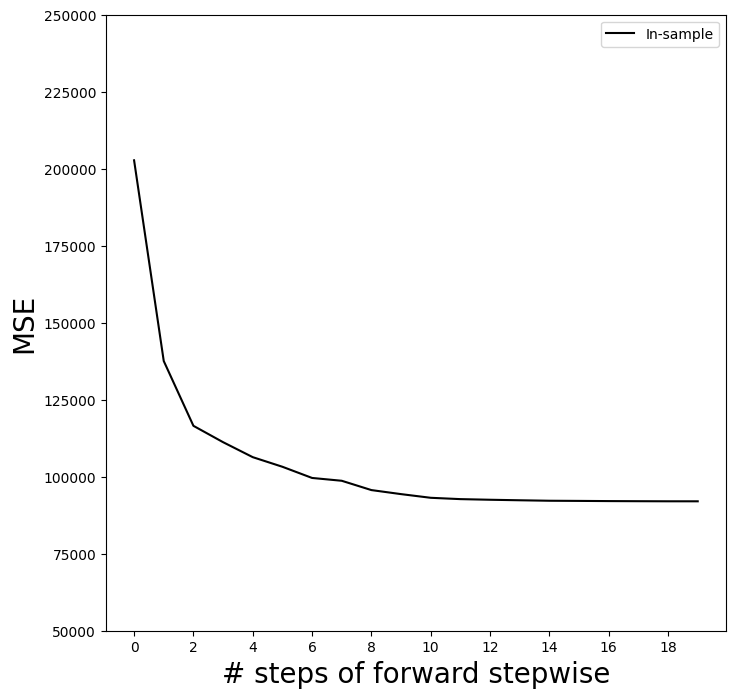

In [20]:
n_steps = insample_mse.shape[0]

mse_fig , ax = subplots(figsize=(8,8))
## 横轴为步数，纵轴为MSE
ax.plot(np.arange(n_steps),
        insample_mse ,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()

ax.set_ylim ([50000 ,250000])
## 注意！！我们这里还没有交叉验证，这里是样本内的MSE

##### 使用交叉验证

这里，我们将使用5折交叉验证计算交叉验证的预测值：

1. 将数据集分成 5 个子集
2. 在 5 次迭代中每次使用 4 个子集作为训练数据，剩余的 1 个子集作为验证数据，即每个子集都会作为一次验证集
3. 所有数据都将作为验证集使用一次，从而得到最终的误差估计

In [21]:
K = 5
## 创建一个 K-fold 交叉验证分割器（KFold）
## random_state=0：设置一个随机种,以确保每次运行时折叠的划分规则是相同的
## 表示在分割数据之前会将数据随机打乱
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)


In [22]:
## 执行交叉验证预测，并返回交叉验证过程中每个样本的预测结果
## full_path：前面所存储的完整路径
Yhat_cv = skm.cross_val_predict(full_path ,
                                Hitters ,
                                Y,
                                cv=kfold)
Yhat_cv.shape ## Yhat_cv 与 Yhat_in 具有相同的形状

(263, 20)

接着，我们可以们计算交叉验证方法下的均方误差（MSE），在此之前，我们必须知道每个测试集对应的训练集

解决方法: kfold.split(Y)：使用之前定义的交叉验证分割器进行迭代。每次迭代返回两个索引数组：
1. train_idx：训练集的索引。
2. test_idx：测试集的索引

由于我们之前固定了随机状态，每次我们将任何与 Y 行数相同的数组进行划分时，都会恢复相同的训练和测试索引


In [23]:
cv_mse = []
## 分别计算每次迭代测试集的MSE，简单平均可以粗略计算出在全局上的MSE
for train_idx , test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx ,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape ## 数组，20步，每步有5个测试集，5个MSE

(20, 5)

In [24]:
cv_mse.mean(1)## 全局上的MSE

array([204139.30692995, 145432.81795577, 133710.24527153, 137396.18786191,
       125048.27123131, 123620.17134613, 119949.01642532, 126682.01732961,
       128152.67228705, 125914.88377827, 124205.51901575, 126396.51208814,
       122166.17871681, 123927.57787306, 123300.517342  , 122288.87151516,
       122152.01805972, 122281.87786874, 122491.94940786, 122698.79900902])

In [25]:
## 计算每个步骤的标准误差，标准误差是 MSE 的标准偏差除以折叠的平方根
## 误差，模型的表现受到不同训练集的影响较大，可能是因为模型对训练集的变化比较敏感，稳定性较差
cv_mse.std(1) / np.sqrt(K)

array([22219.6564189 , 11604.11118684, 11466.86474293, 10265.76734027,
        9334.12188557,  8210.55929276,  8746.14677698, 12882.82376158,
       12314.43399292, 11422.44214895,  9706.67877435, 10398.37701692,
        8954.38482255,  9119.354742  ,  8110.3269643 ,  8400.205605  ,
        8021.86562901,  8118.02030101,  8156.68666987,  8072.17163598])

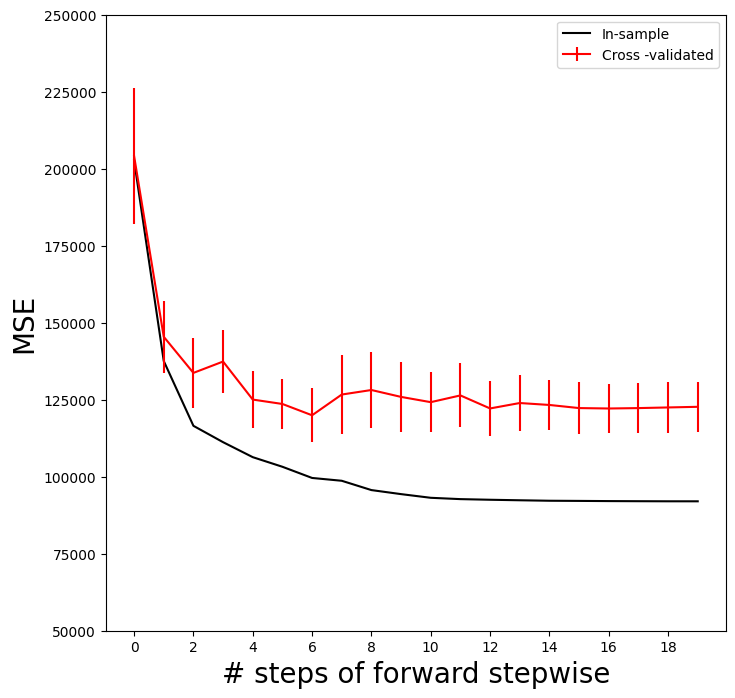

In [26]:
## 绘制交叉验证的均方误差曲线，并添加每个步骤的标准误差
## 模型的平均表现外，模型在不同训练集和测试集划分下的稳定性和可靠性
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross -validated',
            c='r') # color red
ax.set_ylim ([50000 ,250000])
ax.legend()
mse_fig

##### 使用验证集方法
区别：将数据随机划分为两个部分：一个训练集和一个测试集，只划分依次

In [27]:
## 划分训练集和测试集
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.2,
                              random_state=0)

for train_idx , test_idx in validation.split(Y):
    ## 预测
    full_path.fit(Hitters.iloc[train_idx],
                  Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    ## 使用索引的方式区分训练集和验证集
    errors = (Yhat_val - Y[test_idx ,None])**2
    validation_mse = errors.mean(0)

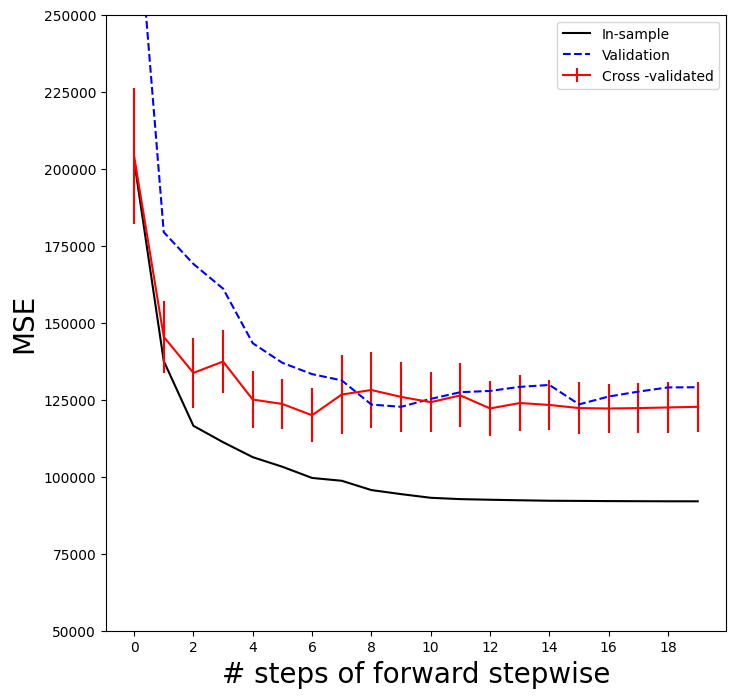

In [28]:
## 绘制验证集的均方误差
ax.plot(np.arange(n_steps),
        validation_mse ,
        'b--', 
        label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim ([50000 ,250000])
ax.legend()
mse_fig

### 2. 收缩方法--Ridge Regression and the Lasso

1. 子集选择法是一个离散的过程——变量要么被保留，要么被丢弃——它通常表现出较高的方差，因此无法减少完整模型的预测误差

2. 收缩方法则更加连续，不太容易受到高波动性的影响。

本节使用sklearn.linear_model包来拟合岭回归和Lasso线性模型，具体来说，使用 skl.ElasticNet() 函数来拟合岭回归和套索回归

#### 2.1 岭回归

岭回归通过对回归系数的大小施加惩罚来收缩它们。岭回归通过最小化一个加权的残差平方和来估计系数，其数学形式如下
$$
\hat{\beta}_{ridge} = \arg\min_{\beta} \left( \sum_{i=1}^{N} \left( y_i - \beta_0 - \sum_{j=1}^{p} x_{ij} \beta_j \right)^2 + \lambda \sum_{j=1}^{p} \beta_j^2 \right)
$$

其中，$\lambda ≥0$,$\lambda$ 是一个复杂度参数，控制收缩的程度： 值越大，收缩的程度越大。

为什么有效？

Example:当线性回归模型中有很多相关变量时，它们的系数可能变得难以确定，并且方差较大。一个变量上极大的正系数可能会被与之相关的变量上极大的负系数所抵消。通过对系数施加大小约束，这个问题得以缓解。

In [29]:
## 去掉截距项
X = X.drop('intercept', axis=1)
X = np.asarray(X)

In [30]:
## 岭回归解在输入变量缩放时不具有等变性，因此通常在求解之前需要对输入数据进行标准化
Xs = X - X.mean(0)[None ,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None ,:]

In [31]:
## 除以Y.std()使得lambda的规模和目标变量 Y 的尺度一致，确保正则化的强度不会因为数据的尺度不同而受到影响
lambdas = 10**np.linspace(8, -2, 100) / Y.std()

In [32]:
## 岭回归：l1_ratio=0
## 【1】第二个元素对应模型的系数
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape ## 19个变量，100种lambda

(19, 100)

In [33]:
## 100个模型的系数存为dataframe，索引为-np.log(lambdas))
## 负对数变换使得 λ 值从大到小排序，方便分析不同 λ 值下系数的变化趋势
soln_path = pd.DataFrame(soln_array.T,
                         columns=design.fit_transform(Hitters).drop('intercept', axis=1).columns ,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


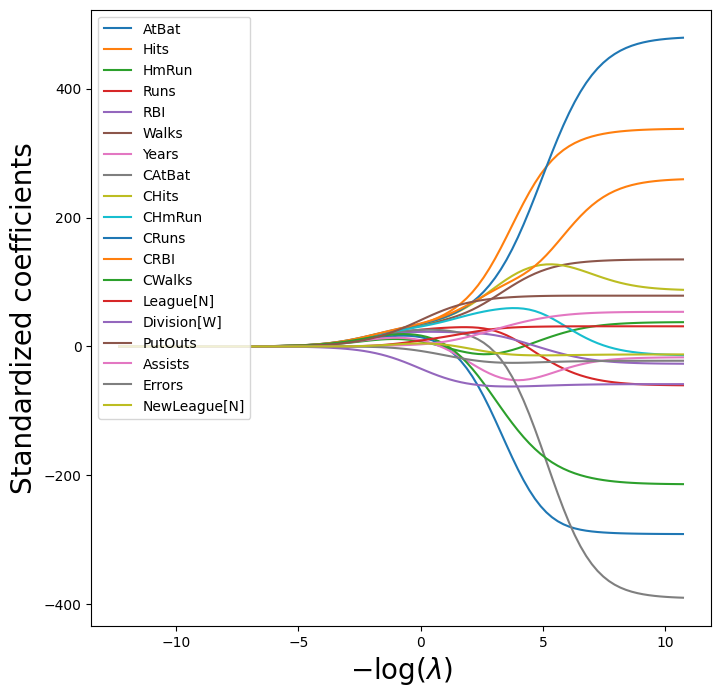

In [34]:
## 系数如何随 λ 值的变化而变化
path_fig , ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
#x
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
#y
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left')

1. 左侧，lambda比较大，即约束比较强的时候，系数值比较小并且有较多的特征变量系数接近于0
2. 右侧，lambda比较小，约束较弱，特征变量的系数值比较大

In [35]:
## lambda为25.5左右时系数的大小
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

In [36]:
## 计算 beta_hat 向量的 L2 范数（即欧几里得范数,惩罚项），它的数学含义是所有系数的平方和的平方根
lambdas[39],np.linalg.norm(beta_hat)

(25.53538897200662, 24.17061720144378)

In [37]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)

(0.24374766133488554, 160.42371017726032)

1. 当lambda较小时，正则化的力度较小，模型可以更自由地拟合数据。这通常会导致模型的系数较大,范数也较大
2. 当lambda较大时，正则化的力度增强，系数会被压缩

In [38]:
## 使用Pipeline对象来将标准化和岭回归模型的拟合步骤结合在一起，相比于上面先标准化再回归更加方便
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True , with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y) ## pipe增加了标准化过程，所以特征变量直接输入X

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.24374766133488554, l1_ratio=0))])

In [39]:
## 岭回归模型中系数的L2范数
np.linalg.norm(ridge.coef_)

160.42371017725904

##### 岭回归的测试误差估计

我们需要使用验证方法或交叉验证来选择调节参数$\lambda$，在选择之前我们需要知道不同选择下模型的表现如何

In [40]:
## 验证集法
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.5,
                              random_state=0)
## lambda设置为0.01，控制模型的正则化强度
ridge.alpha = 0.01
## 交叉验证
results = skm.cross_validate(ridge ,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
## neg_mean_squared_error：取neg_mean_squared_error负值来得到正的MSE
-results['test_score']

array([134214.00419204])

In [41]:
## 设置lambda为10的十次方
ridge.alpha = 1e10
results = skm.cross_validate(ridge ,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

array([231788.32155285])

lambda选择0.01由于选择10^10

使用网格搜索选择最佳的 α 参数来拟合岭回归模型

In [42]:
param_grid = {'ridge__alpha': lambdas}

#pipe：包括数据标准化和岭回归模型。
#param_grid：包含要搜索的参数范围。
#cv：交叉验证的方式，使用之前定义的 验证集方法
#scoring：评分标准
grid = skm.GridSearchCV(pipe,
                        param_grid ,
                        cv=validation ,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))])

In [43]:
## 测试集方法换为交叉验证的方法
grid = skm.GridSearchCV(pipe ,
                        param_grid ,
                        cv=kfold ,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])

Text(0, 0.5, 'Cross -validated MSE')

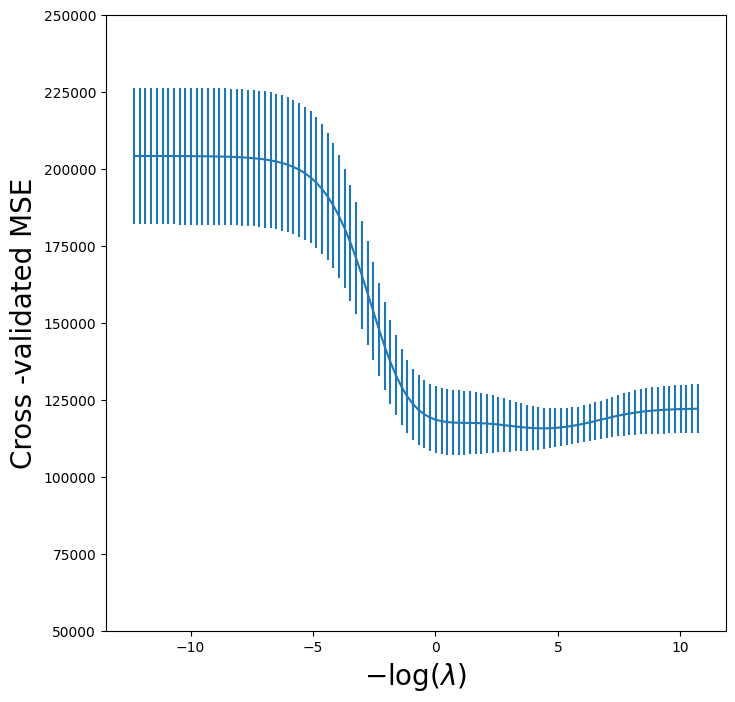

In [44]:
## K折叠交叉验证方法在不同lambda上的表现，从左到右，lambda逐渐减少
ridge_fig , ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim ([50000 ,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated MSE', fontsize=20)

In [45]:
## 创建新的网格调参的对象，性能指标为测试集R方
grid_r2 = skm.GridSearchCV(pipe ,
                           param_grid ,
                           cv=kfold)

grid_r2.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606...
       4.67486141e-03, 3.70474772e-03, 2.93594921e-03, 2.32668954e-03,
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05])})

Text(0, 0.5, 'Cross -validated $R^2$')

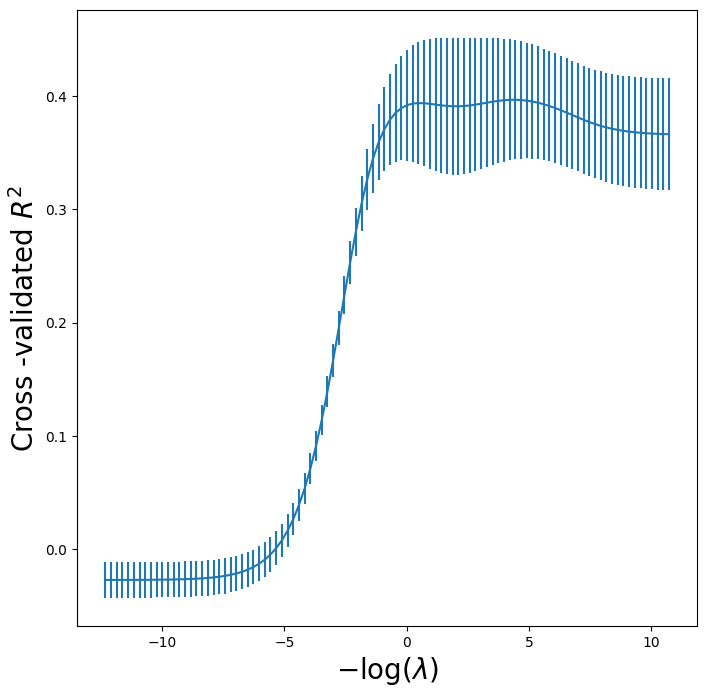

In [46]:
r2_fig , ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K)
            )
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated $R^2$', fontsize=20)

我们可以发现，随着lambda的变化，样本外R方和MSE所暗示的模型性能的变化一致
1. MSE变小
2. 样本外R方变大

#### 快速交叉验证解决方案路径

存在专门的代码来拟合此类路径，并通过交叉验证选择合适的λ值

In [47]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas ,
                           l1_ratio=0,
                           cv=kfold)

pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03,...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

Text(0, 0.5, 'Cross -validated MSE')

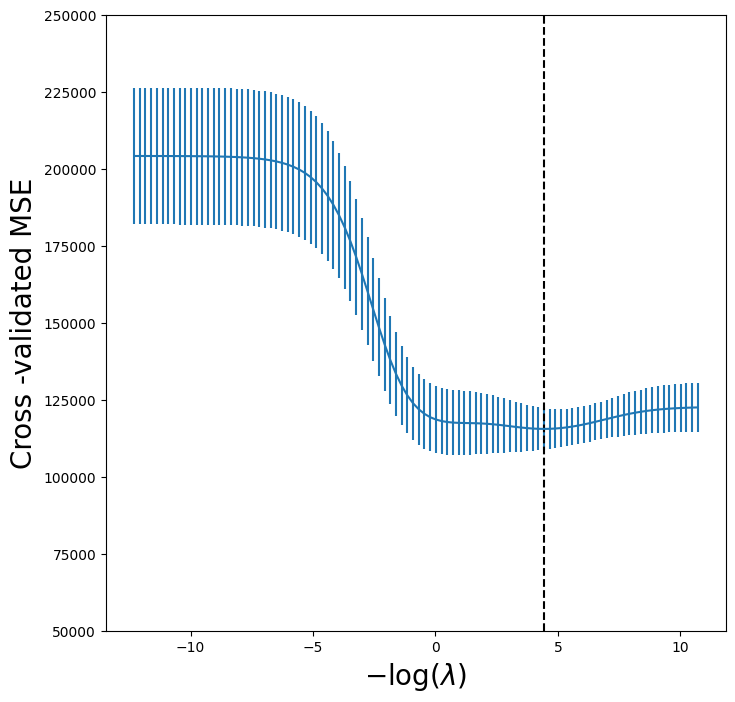

In [48]:
## tuned_ridge 提取了训练好的岭回归模型，从中可以得到交叉验证的均方误差路径
tuned_ridge = pipeCV.named_steps['ridge']

ridgeCV_fig , ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim ([50000 ,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated MSE', fontsize=20)


In [49]:
## 交叉验证路径中的最小均方误差
np.min(tuned_ridge.mse_path_.mean(1))

115526.70630987761

In [50]:
## 对应的系数
tuned_ridge.coef_

array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731984,
        122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
       -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
         40.07350744,  -25.02151514,  -13.68429544])

##### 评估交叉验证岭回归的测试误差

通过交叉验证选择 λ 值会提供一个单一的回归估计量。但是交叉验证已经使用了所有数据来选择 λ 值，因此没有剩余数据来估算测试误差。

1. 将数据初步分为两个不相交的集合：训练集和测试集。
2. 在训练集上拟合一个通过交叉验证调整的岭回归模型
3. 在测试集上评估其性能。我们可以称之为“交叉验证嵌套在验证集方法中”

下面，我们使用 75% 的数据用于训练，25% 用于测试，估计器使用通过 5 折交叉验证调优的岭回归。

In [51]:
## 设置外部验证集
outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=1)
## 内部交叉验证
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True ,
                     random_state=2)

## 岭回归模型
ridgeCV = skl.ElasticNetCV(alphas=lambdas ,
                           l1_ratio=0,
                           cv=inner_cv)

## 组合标准差和岭回归过程
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])

## 交叉验证
results = skm.cross_validate(pipeCV ,
                             X,
                             Y,
                             cv=outer_valid ,
                             scoring='neg_mean_squared_error')
-results['test_score']

array([132393.84003227])

### 2.2 The Lasso

Lasso是一种类似于岭回归的收缩方法，其数学形式如下

$$
\hat{\beta}_{\text{lasso}} = \arg \min_{\beta} \left( \frac{1}{2} \sum_{i=1}^{N} \left( y_i - \beta_0 - \sum_{j=1}^{p} x_{ij} \beta_j \right)^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right). \tag{3.52}
$$

与岭回归不同，Lasso回归使用的是L1正则化，它的惩罚项是系数的绝对值之和。这种方式的特点是，它可以把一些系数直接压缩为零。

In [52]:
##  l1_ratio=1：Lasso
## 之前我们指定了lambdas的值，这里是ElasticNetCV自动生成的，替换为alphas=lambdas没有特别大的差别
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
## 提取拟合好的lasso模型
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_


3.1472370031649866

In [53]:
## 拟合一百次，返回lambda的值和每次拟合的系数
lambdas, soln_array = skl.Lasso.path(Xs,
                                      Y,
                                      l1_ratio=1,
                                      n_alphas =100)[:2]

soln_path = pd.DataFrame(soln_array.T,
                         columns=design.fit_transform(Hitters).drop('intercept', axis=1).columns ,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-5.542369,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
-5.472594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,17.205159,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
-5.402819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,33.250748,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000
-5.333043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.545671,42.024827,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
-5.263268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,13.727251,49.189007,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.086285,-292.618320,330.147359,25.671504,-49.562410,-13.598973,130.583914,-24.123416,-286.579896,31.226178,-0.0,452.829429,229.229316,-209.493673,28.373513,-58.125944,79.096546,49.338699,-20.820927,-9.515995
1.156060,-292.511837,330.496934,26.317012,-50.124459,-14.357879,130.849065,-23.603337,-294.116322,37.120221,-0.0,453.537777,229.848245,-209.616048,28.584855,-58.145706,79.080585,49.655372,-20.923792,-9.725398
1.225835,-292.413043,330.823484,26.918970,-50.648775,-15.065567,131.096456,-23.118630,-301.141293,42.613785,-0.0,454.198913,230.425310,-209.730604,28.781925,-58.164143,79.065724,49.950637,-21.019700,-9.920665


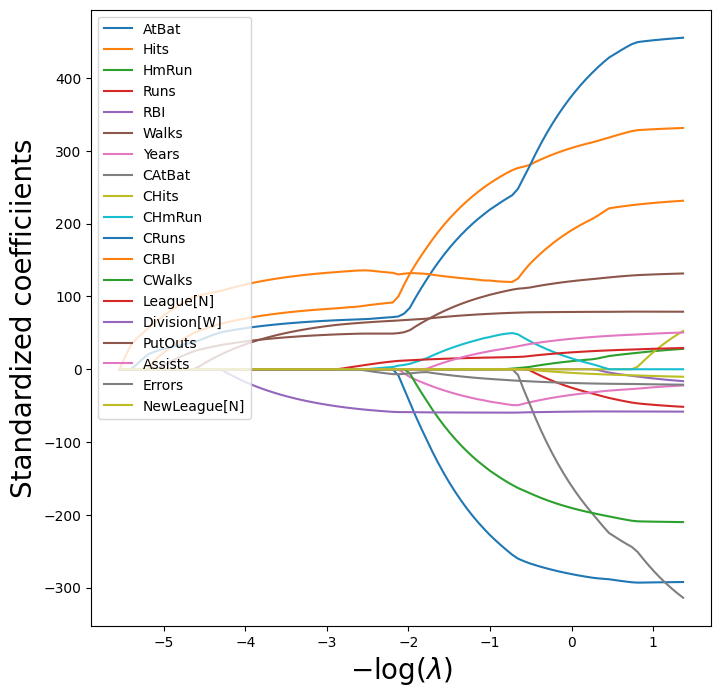

In [54]:
path_fig , ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

根据调节参数的选择，某些系数会被压缩到零：通过增大正则化参数，Lasso 回归会迫使一些系数变为零，从而实现特征选择。与 Ridge回归相比，后者通过对所有特征施加约束，通常不会将系数压缩为零，而是将它们调整为较小的值。

In [55]:
np.min(tuned_lasso.mse_path_.mean(1))

114690.73118253658

最小的交叉验证误差低于空模型和最小二乘法的测试集均方误差（MSE），并且与使用交叉验证选择的Ridge 回归的测试 MSE（115526.71）非常相似。

尽管 Lasso回归通过对一些系数施加零的约束来简化模型，但它仍然能够在预测精度上与岭回归相媲美，甚至在某些情况下更好。因此，Lasso 回归不仅有助于简化模型（通过特征选择），而且可以在测试误差上保持竞争力。

Text(0, 0.5, 'Cross -validated MSE')

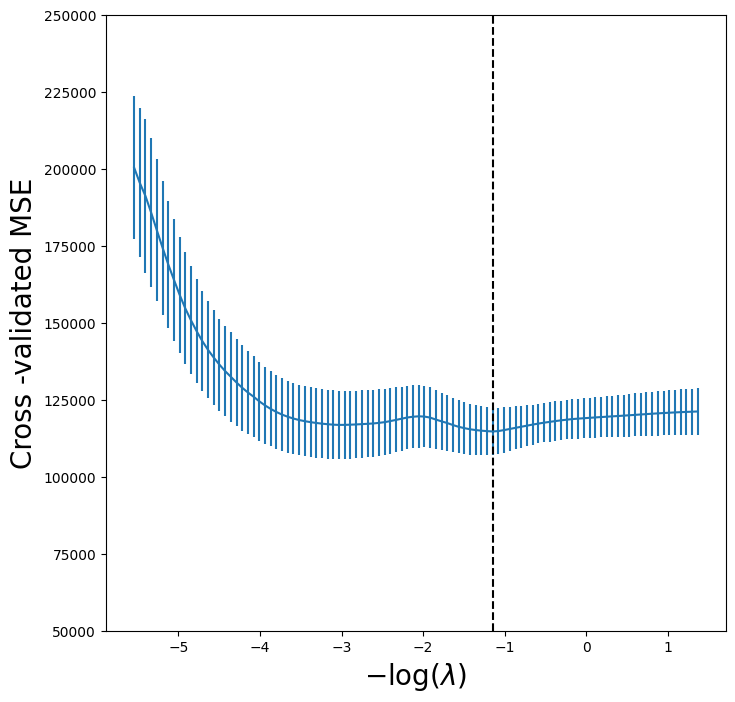

In [56]:
lassoCV_fig , ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
## ax.axvline 用于绘制一条垂直线，表示通过交叉验证选出的最佳lambda
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim ([50000 ,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated MSE', fontsize=20)


In [57]:
tuned_lasso.coef_

array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

## 3. PCR and PLS Regression

在许多情况下，我们有大量的输入，通常这些输入之间高度相关。本节中的方法
1. 生成原始输入 $X_j$ 的少数线性组合 $Z_m, m = 1, \dots, M$
2. 然后将这些 $Z_m$ 作为回归中的输入，替代原始的 $X_j$。
这些方法的不同之处在于线性组合的构造方式。


### 3.1 Principal Components Regression

基本思想：
1. 首先对原始数据进行PCA。即通过对数据进行正交变换，将原始特征投影到一个新的坐标系中，其中的新特征称为“主成分”。这些主成分是原始特征的线性组合，并且按方差大小降序排列。即，第一个主成分包含数据中最大的信息量，第二个主成分包含第二多的信息，以此类推。
2. 选择几个主成分
3. 将主成分与响应变量进行回归

In [58]:
## 提取两个主成分
pca = PCA(n_components=2)
## 线性回归
linreg = skl.LinearRegression()
## 组合步骤
pipe = Pipeline([('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
## 获取回归系数
pipe.named_steps['linreg'].coef_

array([0.09846131, 0.4758765 ])

In [59]:
## 成分分析（PCA） 时，结果会根据数据是否经过标准化而有所不同
## 如果不进行标准化，PCA 可能会过度依赖于尺度较大的特征，导致结果失真
pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([106.36859204, -21.60350456])

In [60]:
## 网格调参选择1:19个主成分
param_grid = {'pca__n_components': range(1, 20)}

grid = skm.GridSearchCV(pipe ,
                        param_grid ,
                        cv=kfold ,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

(50000.0, 250000.0)

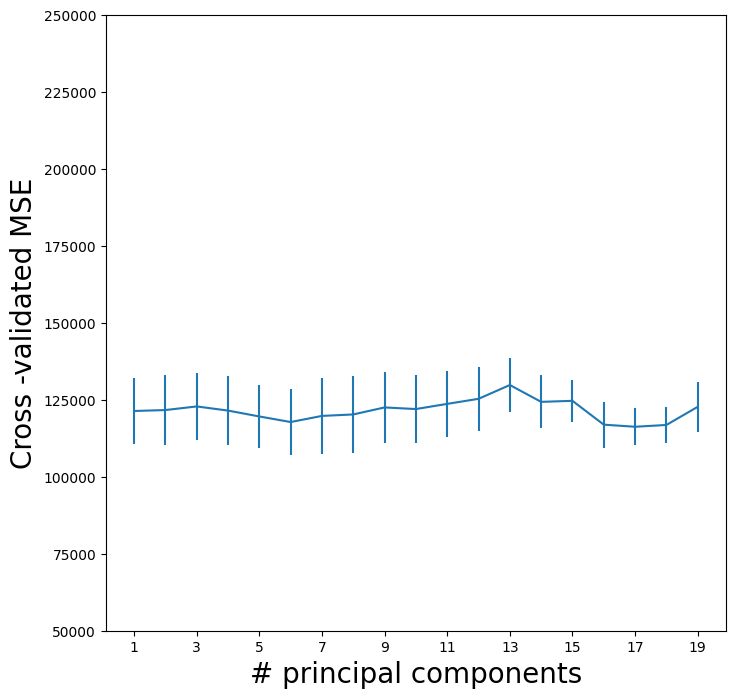

In [61]:
## 绘图
pcr_fig , ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp ,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross -validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp [::2])
ax.set_ylim ([50000 ,250000])

1. 最小的交叉验证误差发生在使用 17 个主成分时
2. 当模型中仅包含一个主成分时，交叉验证误差几乎相同。这表明，使用较少的主成分可能就足够了

In [62]:
## 评估一个只有截距项（没有实际预测变量）的模型的性能，n_components=0
Xn = np.zeros((X.shape[0], 1))##行与X相同，1列全为0

cv_null = skm.cross_validate(linreg ,
                             Xn,
                             Y,
                             cv=kfold ,
                             scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()

204139.30692994667

相较于上图1:19个主成分的MSE，可以看出即使只增加一个主成分，已经带来巨大的优势

In [63]:
## 提取十个主成分
pca = PCA(n_components=10)
## 线性回归
linreg = skl.LinearRegression()
## 组合步骤
pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)

## 表示每个主成分（principal component）所解释的方差占总方差的比例
pipe.named_steps['pca'].explained_variance_ratio_

array([0.3831424 , 0.21841076, 0.10686359, 0.0819252 , 0.05256081,
       0.04344504, 0.03628108, 0.02700156, 0.01319648, 0.00972722])

1. 设置 M = 1 时，仅捕获了 38.31% 的方差
2. M = 2 时则额外捕获了 21.84%，使总方差为 60.15%
3. ...

### 3.2 PLS

PLS旨在通过找到一组新的潜在变量（称为成分），最大化这些成分与响应变量（因变量）之间的相关性。这些成分是从原始的预测变量（自变量）中提取的

1. 提取成分：从原始的预测变量（X）中提取新的潜在变量，这些潜在变量是自变量的线性组合。
2. 最大化相关性：这些成分不仅要解释自变量中的方差，还要与响应变量（Y）有很强的相关性（协方差）。
3. 回归预测：用这些新的成分来拟合响应变量，进行预测。


PLS不仅考虑自变量的方差，还会考虑它们与响应变量之间的相关性。因此，PLS通常能提供比PCA更具预测性的结果


In [64]:
pls = PLSRegression(n_components=2,
                    scale=True)
pls.fit(X, Y)

PLSRegression()

In [65]:
## 网格调参对象
param_grid = {'n_components':range(1, 20)}
grid = skm.GridSearchCV(pls ,
                        param_grid ,
                        cv=kfold ,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

(50000.0, 250000.0)

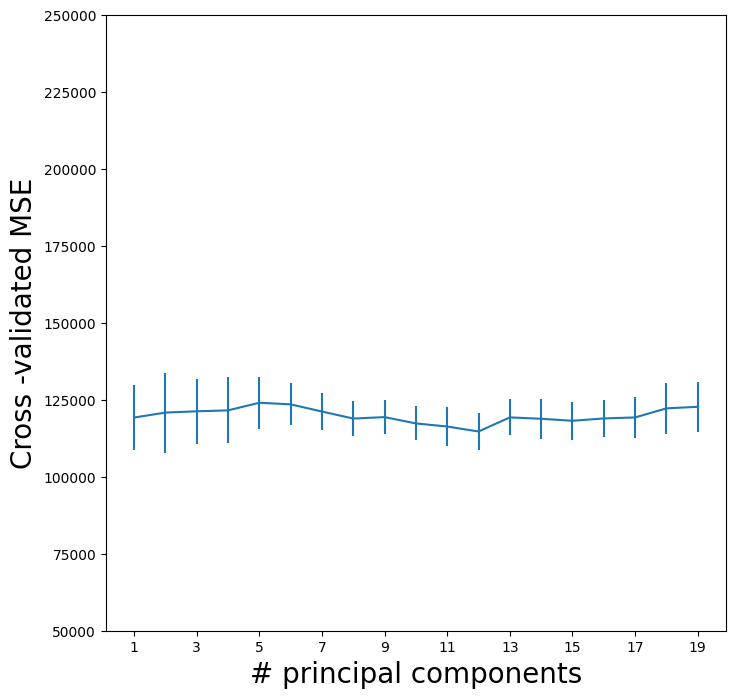

In [66]:
pls_fig , ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp ,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))

ax.set_ylabel('Cross -validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp [::2])
ax.set_ylim ([50000 ,250000])

交叉验证（CV）误差在使用12个主成分时最小，尽管在使用更少的主成分（如2或3个）时，误差与12个主成分的差异几乎可以忽略不计。